In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# Функция для аугментации данных с шумом и джиттером
def augment_data_with_noise(X, y, num_augmentations=10, noise_factor=0.05, jitter_factor=0.03):
    augmented_data = []
    augmented_labels = []
    
    for index in range(len(X)):
        signal = X.iloc[index].values
        label = y.iloc[index]

        # Оригинальный сигнал
        augmented_data.append(signal)
        augmented_labels.append(label)
        
        # Аугментированные сигналы
        for _ in range(num_augmentations):
            # Добавляем шум
            noise = np.random.normal(0, noise_factor, size=signal.shape)
            noisy_signal = signal + noise
            augmented_data.append(noisy_signal)
            augmented_labels.append(label)
            
            # Добавляем джиттер
            jitter = np.random.normal(0, jitter_factor, size=signal.shape)
            jittered_signal = signal + jitter
            augmented_data.append(jittered_signal)
            augmented_labels.append(label)

    return np.array(augmented_data), np.array(augmented_labels)

In [3]:

df = pd.read_csv('D:/VECG/catboost/features.csv')
X = df.drop(columns=['Class', 'Patient_Name'])
y = df['Class']
X_ill = X[y == 1]  # Больные
X_healthy = X[y == 0]  # Здоровые
y_ill = y[y == 1]
y_healthy = y[y == 0]

In [4]:
X_train_ill, X_test_ill, y_train_ill, y_test_ill = train_test_split(X_ill, y_ill, train_size=30, random_state=42)
X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(X_healthy, y_healthy, train_size=30, random_state=42)


In [5]:
X_train = pd.concat([X_train_ill, X_train_healthy], axis=0)
y_train = pd.concat([y_train_ill, y_train_healthy], axis=0)
X_test = pd.concat([X_test_ill, X_test_healthy], axis=0)
y_test = pd.concat([y_test_ill, y_test_healthy], axis=0)

In [6]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [7]:
test_output_path = 'D:/VECG/catboost/test_features.csv'
pd.concat([X_test, y_test], axis=1).to_csv(test_output_path, index=False)
print(f"Тестовые данные сохранены в {test_output_path}")

Тестовые данные сохранены в D:/VECG/catboost/test_features.csv


In [8]:
print(f"Количество больных в тренировочной выборке: {sum(y_train == 1)}")
print(f"Количество здоровых в тренировочной выборке: {sum(y_train == 0)}")
print(f"Количество больных в тестовой выборке: {sum(y_test == 1)}")
print(f"Количество здоровых в тестовой выборке: {sum(y_test == 0)}")

Количество больных в тренировочной выборке: 30
Количество здоровых в тренировочной выборке: 30
Количество больных в тестовой выборке: 32
Количество здоровых в тестовой выборке: 79


In [9]:
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])


In [10]:
# аугментация на тренировочных данных
X_train_augmented, y_train_augmented = augment_data_with_noise(X_train_numeric, y_train, num_augmentations=20)
print(f"Количество аугментированных данных: {len(X_train_augmented)}")

Количество аугментированных данных: 2460


In [11]:
# Стандартизация данных
scaler = StandardScaler()
X_train_augmented_scaled = scaler.fit_transform(X_train_augmented)

# Стандартизация тестовых данных
X_test_scaled = scaler.transform(X_test_numeric)

d:\Python 3.11\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [12]:
# Обучение модели CatBoost
catboost_model = CatBoostClassifier(depth=5, learning_rate=0.1, iterations=200, random_state=42)

# Обучение на аугментированных данных
catboost_model.fit(X_train_augmented_scaled, y_train_augmented, verbose=False)

# Предсказания на тестовых данных
y_pred = catboost_model.predict(X_test_scaled)

In [13]:
# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

Accuracy: 0.6576576576576577
F1 Score: 0.6675475475475475
Recall: 0.6576576576576577


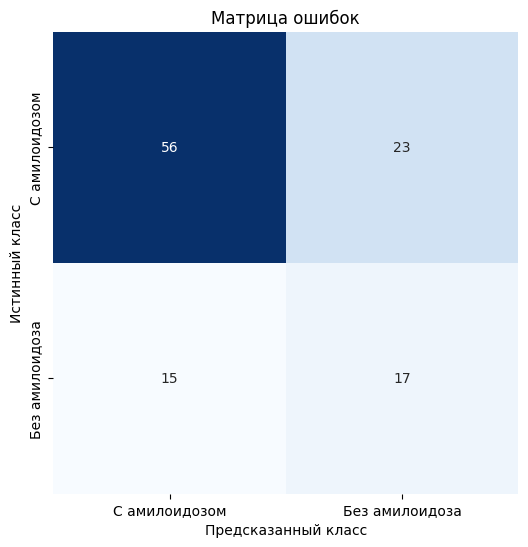

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['С амилоидозом', 'Без амилоидоза'],
            yticklabels=['С амилоидозом', 'Без амилоидоза'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()
